# Dataloader and Data Exploration

- Data Collection
- Data Visualization 
- Data Splitting (Train Test Validation)


In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd 
from datetime import datetime
import tensorflow as tf 
from tqdm import tqdm
import pandas as pd 
import numpy as np 
import cv2 
import os 
import pickle 
import random 

from config import * 

# Image augmentation 
import albumentations as A

In [4]:
def create_training_data():
    dataset = []
    for category in CATEGORIES:
        path = os.path.join(DATA_DIR ,category) 
        class_num = CATEGORIES.index(category)  
        for img in tqdm(os.listdir(path)):  
            try:
                img_array = cv2.imread(os.path.join(path,img ) ,cv2.COLOR_BGR2RGB)
                img_array = cv2.normalize(img_array , None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                img_array = cv2.resize( img_array, ( 256, 256)) 
                for i in range(IMAGE_AUGMENT_MULTIPLEX):
                    transform = A.Compose([
                        A.RandomCrop(width=256, height=256),
                        A.HorizontalFlip(p=0.5),
                        A.RandomBrightnessContrast(p=0.2),
                        A.Affine(),
                        A.CoarseDropout(),
                        A.Lambda(),
                        A.RandomRotate90(),
                        A.RandomScale(),
                        A.SafeRotate(),
                        A.ShiftScaleRotate(),
                        A.Transpose()

                    ])
                    transformed = transform(image=img_array )
                    img_array_resize = cv2.resize( transformed["image"], ( IMG_SIZE, IMG_SIZE)) 
                    if( np.array( img_array_resize ).shape == INPUT_SHAPE ):
                        dataset.append([img_array_resize,class_num])
            except Exception as e: 
                return 
    random.shuffle(dataset)
    return dataset


def data_label_feature(dataset):
    X = []
    y = []
    for features,label in dataset:
        X.append(features)
        y.append(label) 
    return np.array(X), np.array(y)

dataset = create_training_data()
X,y = data_label_feature(dataset)
X.shape, y.shape

100%|██████████| 1378/1378 [00:24<00:00, 57.19it/s]


((48788, 50, 50, 3), (48788,))

Text(0.5, 1.0, 'Some examples of the Dataset')

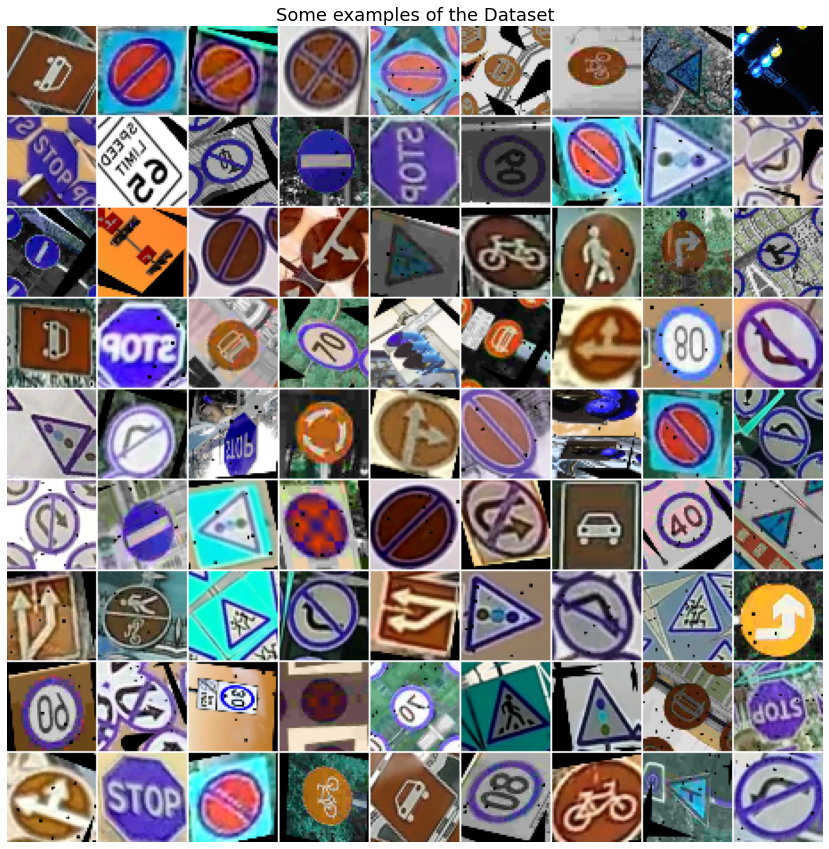

In [5]:
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid
# Visualizing some examples of training data
examples = X[:81, :, :]
# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of the Dataset', fontsize=18)

11.00% 	  5368 - allowed-direction
11.61% 	  5664 - allowed-signs
11.04% 	  5388 - cross-walk
13.36% 	  6520 - probihited-direction
11.75% 	  5732 - probihited-signs
10.93% 	  5332 - speed-limit
10.40% 	  5076 - stop-sign
8.60% 	  4196 - traffic-sign
11.30% 	  5512 - warning-sign
----------------------------------------------------------------
Mean -  5420.888888888889
Median -  5388.0
Standard deviation -  577.6697334876169
----------------------------------------------------------------
Total -  48788
       Total number
count      9.000000
mean    5420.888889
std      612.711279
min     4196.000000
25%     5332.000000
50%     5388.000000
75%     5664.000000
max     6520.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   data          9 non-null      object
 1   Total number  9 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 2

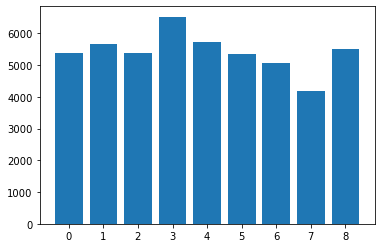

In [29]:
# Total number of each class with percentage 
def each_class_eval(X,y):
    unique, counts = np.unique(y, return_counts=True)
    total =  np.sum(counts) 
    for label, count in zip(unique, counts):
        print(f'{ count/total*100:0.02f}% \t ',count, '-',CATEGORIES[label])
    plt.bar(unique, counts)
    plt.xticks(unique)
    print('----------------------------------------------------------------')
    print( 'Mean - ', np.mean(counts))
    print( 'Median - ', np.median(counts))
    print( 'Standard deviation - ', np.std(counts))
    print('----------------------------------------------------------------')
    print( 'Total - ',   total)
    df = pd.DataFrame({'data': CATEGORIES, 'Total number':counts})
    # print(df.info())
    print(df.describe())
    print(df.info())
    print('----------------------------------------------------------------')
each_class_eval(X,y)

In [30]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.33, random_state=42)

=========================== Train dataset ===========================
11.19% 	  3659 - allowed-direction
11.52% 	  3764 - allowed-signs
11.07% 	  3617 - cross-walk
13.18% 	  4308 - probihited-direction
11.75% 	  3841 - probihited-signs
11.08% 	  3621 - speed-limit
10.18% 	  3329 - stop-sign
8.59% 	  2808 - traffic-sign
11.44% 	  3740 - warning-sign
----------------------------------------------------------------
Mean -  3631.8888888888887
Median -  3659.0
Standard deviation -  380.29299945186835
----------------------------------------------------------------
Total -  32687
       Total number
count      9.000000
mean    3631.888889
std      403.361638
min     2808.000000
25%     3617.000000
50%     3659.000000
75%     3764.000000
max     4308.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   data          9 non-null      object
 1   Total nu

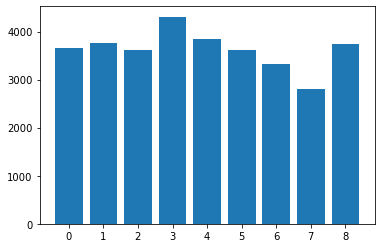

In [31]:
print('=========================== Train dataset ===========================')
each_class_eval(X_train,y_train)

=========================== Test dataset ===========================
10.61% 	  1709 - allowed-direction
11.80% 	  1900 - allowed-signs
11.00% 	  1771 - cross-walk
13.74% 	  2212 - probihited-direction
11.74% 	  1891 - probihited-signs
10.63% 	  1711 - speed-limit
10.85% 	  1747 - stop-sign
8.62% 	  1388 - traffic-sign
11.01% 	  1772 - warning-sign
----------------------------------------------------------------
Mean -  1789.0
Median -  1771.0
Standard deviation -  204.7535103484187
----------------------------------------------------------------
Total -  16101
       Total number
count      9.000000
mean    1789.000000
std      217.173893
min     1388.000000
25%     1711.000000
50%     1771.000000
75%     1891.000000
max     2212.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   data          9 non-null      object
 1   Total number  9 non-nu

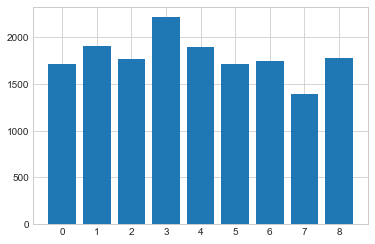

In [34]:
print('=========================== Test dataset ===========================')
each_class_eval(X_test,y_test)

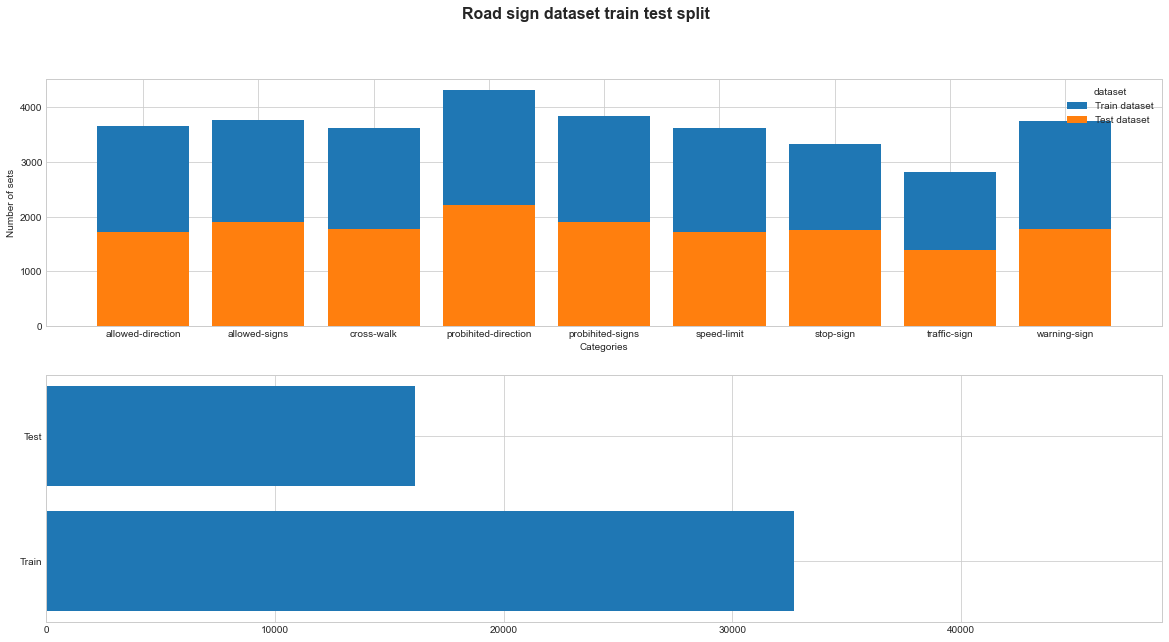

In [33]:
def comparing_dataset(X,y, X_train, X_test, y_train, y_test):
    # Customizing the Y and X axis  
    unique, counts = np.unique(y, return_counts=True)
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    
    plt.style.use('seaborn-whitegrid')
    fig, (ax0, ax1) = plt.subplots( nrows=2, ncols=1, figsize=(20,10) )
    ax0.bar(unique_train, counts_train)
    ax0.bar(unique_test, counts_test)
    ax0.set_xticks(range(len(unique)))
    ax0.set_xticklabels([ CATEGORIES[i] for i in unique])
    ax0.set_ylabel("Number of sets")
    ax0.set_xlabel("Categories")
    ax0.legend(['Train dataset','Test dataset'], title='dataset')
    
    ax1.set_xlim( [0, sum(counts)])
    ax1.barh(['Train', 'Test'], [np.sum(counts_train), np.sum(counts_test)])
    fig.suptitle("Road sign dataset train test split", fontsize=16, fontweight='bold')
    

comparing_dataset(X,y, X_train, X_test, y_train, y_test)

In [10]:


# One hot encode for classification problem
# y = tf.keras.utils.to_categorical(y, len(CATEGORIES))
# y_test = tf.keras.utils.to_categorical(y_test, len(CATEGORIES))
# y_train = tf.keras.utils.to_categorical(y_train, len(CATEGORIES))

def save_dataset(dir, X,y):
    for image, label in zip(X,y):
        path = os.path.join(SAVE_DIR,dir, str(label))
        if not os.path.exists(path):
            os.makedirs(path)
        # Unique Data naming 
        dt = datetime.now() 
        ts = datetime.timestamp(dt)
        img_name = str(ts)+"-Nihogalog-"+str(label)+".jpg"
        img_path = os.path.join(path, img_name )
        image = cv2.convertScaleAbs(image, alpha=(255.0))
        cv2.imwrite(img_path, image)
        
save_dataset('testing',X_test,y_test)
save_dataset('training',X_train,y_train)
save_dataset('data',X,y)

print('========== [ Traing set ] ========== ')
print('X train - ',  X_train.shape)
print('y train - ', y_train.shape)
print("")
print('=========== [ Test set ] ===========')
print('X train - ',  X_test.shape)
print('y train - ', y_test.shape)
print("")
print('=========== [ Total set ] ===========')
print('X train - ',  X.shape)
print('y train - ', y.shape)

========== [ Traing set ] ========== 
X train -  (32687, 50, 50, 3)
y train -  (32687,)

=========== [ Test set ] ===========
X train -  (16101, 50, 50, 3)
y train -  (16101,)

=========== [ Total set ] ===========
X train -  (48788, 50, 50, 3)
y train -  (48788,)
